In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # second gpu

In [3]:
from tensorflow.compat.v1.keras.backend import get_session
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

2023-10-20 06:59:49.061771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 06:59:49.669634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jovyan/.conda/envs/env-3.8/lib/:/home/jovyan/.conda/envs/env-3.8/lib/python3.8/site-packages/nvidia/cudnn/lib:/home/jovyan/.conda/envs/env-3.8/lib/:/home/jovyan/.conda/envs/env-3.8/lib/python3.8/site-packages/nvidia/cudnn/lib:
2023-10-20 06:59:49.669687: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import cycle
from ruptures.utils import pairwise
from sklearn.model_selection import train_test_split
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG
import shap
import matplotlib.pyplot as plt
import ruptures as rpt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.tree import DecisionTreeClassifier
from aeon.datasets import load_classification
from windowshap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP
import time
from tslearn.clustering import KShape
from kshape.core import KShapeClusteringCPU
from keras.models import Model
from kshape.core_gpu import KShapeClusteringGPU
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Real Data example

In [6]:
# convlstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import ConvLSTM2D, Conv2DTranspose, Conv2D,ConvLSTM1D, Conv1DTranspose, Conv1D
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor
 
def load_dataset_aeon(dsname):
    X, y, meta_data = load_classification(dsname)
    X = np.moveaxis(X,1,2)
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    trainX, testX, trainy, testy= train_test_split(X,y)
    
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy
 
# fit and evaluate a model
def train_model(trainX, trainy, testX, testy, encoder):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps/n_steps)

    inputs = Input(shape=(trainX.shape[1:]))
    embedding = encoder(inputs)
    dropout = Dropout(0.5)(embedding)
    x= Flatten(name='embedding')(dropout)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model


def train_lstmconv_ae(trainX, testX, kernel=11):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps/n_steps)
    #n_steps, n_length = 4, 32 #todo this has to be dividers of trainX.shape[1]
    #trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    #testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    print(f'Input shape (time, rows, channels): {(n_steps, n_length, n_features)}')
    model = Sequential()
    model.add(Reshape((n_steps, n_length, n_features), input_shape=trainX.shape[1:]))
    model.add(ConvLSTM1D(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1, 
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(ConvLSTM1D(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1, 
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Conv1DTranspose(filters = 32, kernel_size=kernel, padding='same', activation='relu', strides=1)))
    model.add(TimeDistributed(Conv1DTranspose(filters = 64, kernel_size=kernel, padding='same', activation='relu', strides=1)))
    model.add(TimeDistributed(Conv1DTranspose(filters = n_features, kernel_size=kernel, padding='same', strides=1)))
    model.add(Reshape((n_steps*n_length, n_features)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    print(model.summary())
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
    return mse, model



def train_lstmconv_ae_functional(trainX, testX, kernel=11):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps/n_steps)
    #n_steps, n_length = 4, 32 #todo this has to be dividers of trainX.shape[1]
    #trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    #testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    print(f'Input shape (time, rows, channels): {(n_steps, n_length, n_features)}')
    inputs = Input(shape=(trainX.shape[1:]))
    r = Reshape((n_steps, n_length, n_features), input_shape=trainX.shape[1:])(inputs)
    encoder = ConvLSTM1D(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1, 
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features))(r)
    encoder = ConvLSTM1D(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1, 
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features))(encoder)
    
    dropout = Dropout(0.5)(encoder)
    
    decoder =TimeDistributed(Conv1DTranspose(filters = 32, kernel_size=kernel, padding='same', activation='relu', strides=1))(dropout)
    decoder = TimeDistributed(Conv1DTranspose(filters = 64, kernel_size=kernel, padding='same', activation='relu', strides=1))(decoder)
    decoder = TimeDistributed(Conv1DTranspose(filters = n_features, kernel_size=kernel, padding='same', strides=1, activation='linear'))(decoder)
    output = Reshape((n_steps*n_length, n_features))(decoder)
    
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    print(model.summary())
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)


    #save encoder
    
    encoder_model = Model(inputs=inputs, outputs=encoder)
    encoder_model.save(f'results/metropt/model_lstmconv_encoder.h5',save_format='h5')
    return mse, model,encoder_model

def train_conv_ae(trainX, testX):
    verbose, epochs, batch_size = 0, 25, 64
    model = keras.Sequential([
        Input(shape=(trainX.shape[1], trainX.shape[2])),
        Conv1D(
            filters=128, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1D(
            filters=64, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1DTranspose(
            filters=128, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(filters=trainX.shape[2], kernel_size=7, padding="same"),
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
    return mse, model

def train_lstm_ae(trainX, testX):
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    model = keras.Sequential([
        Input(shape=(n_timesteps, n_features)),
        Bidirectional(LSTM(128, activation='relu')),
        RepeatVector(n_timesteps),
        Dropout(0.5),
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
        TimeDistributed(Dense(20))
    ])
                             
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
    return mse, model




In [7]:
import pickle
import os
import keras
def save_bundle(model, trainX,trainy,testX,testy,svtr,svts, dsname, dir='./results'):
    if not os.path.isdir(f'{dir}/{dsname}'):
        os.makedirs(f'{dir}/{dsname}')

    model.save(f'{dir}/{dsname}/model.h5',save_format='h5')
    pickle.dump(trainX, open(f'{dir}/{dsname}/trainX.pickle','wb'))
    pickle.dump(trainy, open(f'{dir}/{dsname}/trainy.pickle','wb'))
    pickle.dump(testX, open(f'{dir}/{dsname}/testX.pickle','wb'))
    pickle.dump(testy, open(f'{dir}/{dsname}/testy.pickle','wb'))
    pickle.dump(svtr, open(f'{dir}/{dsname}/svtr.pickle','wb'))
    pickle.dump(svts, open(f'{dir}/{dsname}/svts.pickle','wb'))

    
def load_bundle(dsname, dir='./results'):
    model = keras.models.load_model(f'{dir}/{dsname}/model.h5')
    
    trainX= pickle.load( open(f'{dir}/{dsname}/trainX.pickle','rb'))
    trainy = pickle.load(open(f'{dir}/{dsname}/trainy.pickle','rb'))
    testX= pickle.load(open(f'{dir}/{dsname}/testX.pickle','rb'))
    testy= pickle.load(open(f'{dir}/{dsname}/testy.pickle','rb'))
    svtr = pickle.load(open(f'{dir}/{dsname}/svtr.pickle','rb'))
    svts = pickle.load(open(f'{dir}/{dsname}/svts.pickle','rb'))

    return model, trainX,trainy,testX,testy,svtr,svts

## Metro PT


In [8]:
resampling = '60s'
metro_o = pd.read_csv('../../fast/metropt/dataset_train.csv')
features_o = [f for f in metro_o.columns if f not in ['gpsLong', 'gpsLat','gpsSpeed', 'gpsQuality']]
metro_o = metro_o[features_o]
#toido: groupby 60 sek, mean,

In [9]:
metro_o['timestamp'] =metro_o['timestamp'].astype('datetime64[ns]') 
if resampling is not None:
    metro = metro_o.set_index('timestamp').resample(resampling).mean().reset_index().dropna()
else:
    metro=metro_o

In [10]:
mms = MinMaxScaler()
healthy = metro[metro['timestamp']<'2022-02-01']
features = [f for f in healthy if f not in ['timestamp','gpsLong', 'gpsLat','gpsSpeed', 'gpsQuality']]
healthy.loc[:,features]= mms.fit_transform(healthy[features])

In [11]:
window = 30
stride = 1 #todo or make it lambda random form a range 1-5?
start=0
X = list()
while start+window <= healthy.shape[0]:
    X.append(healthy.iloc[start:start+window, 1:].T.values)
    start=start+stride
    

In [12]:
healthyX = np.moveaxis(np.array(X),1,-1)

In [13]:
healthyX.shape

(37064, 30, 16)

In [14]:
trainX, testX= train_test_split(healthyX, test_size=0.1)

In [15]:
err_lstmconv_ae,model_lstmconv_ae,encoder=train_lstmconv_ae_functional(trainX, trainX)
model_lstmconv_ae.save(f'results/metropt/model_lstmconv_ae.h5',save_format='h5')
err_lstmconv_ae

Input shape (time, rows, channels): (3, 10, 16)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 3, 10, 16)         0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 3, 10, 64)         225536    
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 3, 10, 32)         135296    
                                                                 
 dropout (Dropout)           (None, 3, 10, 32)         0         
                                                                 
 time_distributed (TimeDistr  (None, 3, 10, 32)        11296     
 ibuted)                                                         
             

2023-10-20 07:00:15.145779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 07:00:15.316117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21138 MB memory:  -> device: 0, name: NVIDIA RTX A5500, pci bus id: 0000:51:00.0, compute capability: 8.6
2023-10-20 07:00:15.348386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-10-20 07:00:15.582036: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/time_distributed_2/bias/v/Assign' id:2878 op device:{requested: '', assigned: ''} def:{{{node training/Adam/time_distributed_2/bias/v/Assign}} = AssignVariableOp[_has_manual_contro

0.00044723542

In [16]:
# err_lstmconv_ae,model_lstmconv_ae=train_lstmconv_ae(trainX, trainX)
# model_lstmconv_ae.save(f'results/metropt/model_lstmconv_ae.h5',save_format='h5')
# err_lstmconv_ae

## Detect anomalies by plotting reconstruction error

In [21]:
realdata = metro[metro['timestamp']>='2022-02-01'] 
realdata.loc[:,features]= mms.transform(realdata[features])
stride = window #for test data we do not need overlapping
start=0
X = list()
timestamps =list()
while start+window <= realdata.shape[0]:
    X.append(realdata.iloc[start:start+window, 1:].T.values)
    timestamps.append(realdata.iloc[start].timestamp)
    start=start+stride
realX = np.moveaxis(np.array(X),1,-1)

In [22]:
reconstructedRealX = model_lstmconv_ae.predict(realX)
#reconstructedRealX = model_lstm_ae.predict(realX)
#reconstructedRealX = model_conv_ae.predict(realX)

2023-10-20 07:06:19.482556: W tensorflow/c/c_api.cc:291] Operation '{name:'reshape_1/Reshape' id:826 op device:{requested: '', assigned: ''} def:{{{node reshape_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](time_distributed_2/Reshape_1, reshape_1/Reshape/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [23]:
reconstructedRealX.shape

(4753, 30, 16)

In [24]:
recerr=(reconstructedRealX-realX)

In [25]:
recerr.shape

(4753, 30, 16)

In [26]:

recerr_agg=np.mean(np.mean(np.abs(recerr),axis=1),axis=1)
recerr_agg_idx = np.argmax(np.mean(np.abs(recerr),axis=1),axis=1)

In [27]:
recerr_agg_df=pd.DataFrame({'timestamp':timestamps, 'erro':recerr_agg})

In [28]:
from scipy.signal import butter,filtfilt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def exponential_smoothing(series, alpha):
    """
    Perform exponential smoothing on a pandas Series.

    Parameters:
    series (pd.Series): Input time series as a pandas Series.
    alpha (float): Smoothing parameter (0 < alpha < 1).

    Returns:
    pd.Series: Exponentially smoothed time series.
    """
    smoothed_values = [series.iloc[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)

    return pd.Series(smoothed_values, index=series.index)

recerr_agg_df['err']=recerr_agg_df['erro']
#recerr_agg_df['err'] = butter_lowpass_filter(recerr_agg_df['erro'], cutoff =5 , fs=1000)
recerr_agg_df['err']=exponential_smoothing(recerr_agg_df['erro'],alpha=0.5)

In [29]:
from tsproto import outliers
i,l,u = outliers(recerr_agg_df['err'],multiplier=1.5)

(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

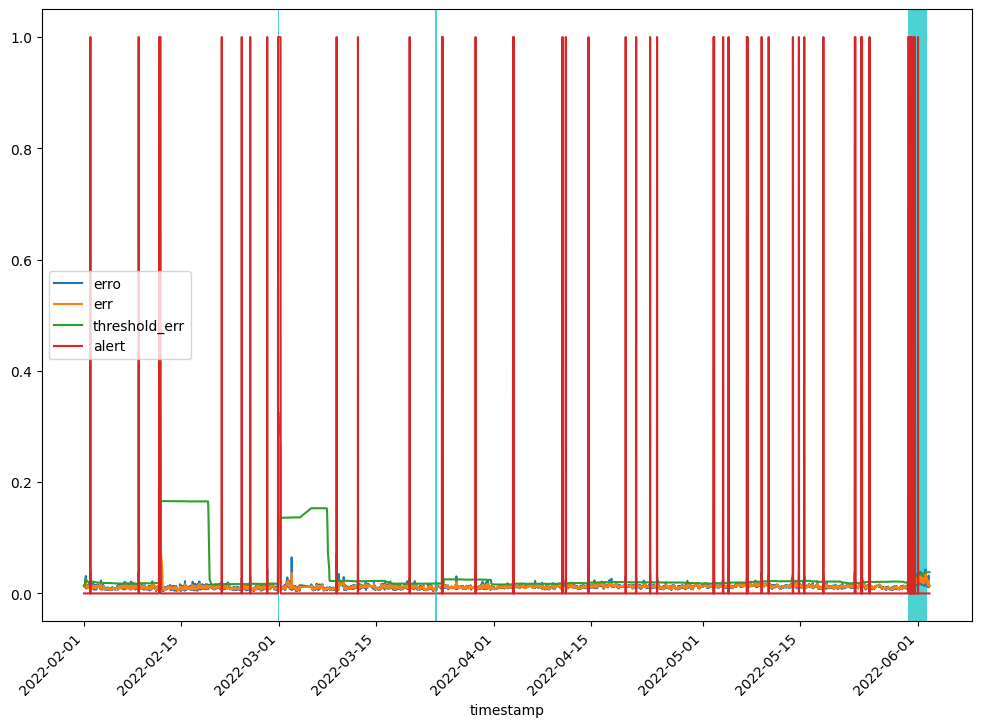

In [30]:
#TODO: mask anomalies that have been previously detected as anomalies
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
fig, ax = plt.subplots(1,1, figsize=(12,9))

rolling_buffer = '7d'

recerr_agg_df['timestamp'] = recerr_agg_df['timestamp'].astype('datetime64[ns]')
err = recerr_agg_df.set_index('timestamp')
err.loc[:,"threshold_err"] = (err.rolling(rolling_buffer).mean()+3*err.rolling(rolling_buffer).std())['err']
err['alert'] = (err['err']>err['threshold_err']).astype(int)#/2
err.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00','2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation = 45)

In [31]:
err[err['alert']>0].shape

(102, 4)

(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

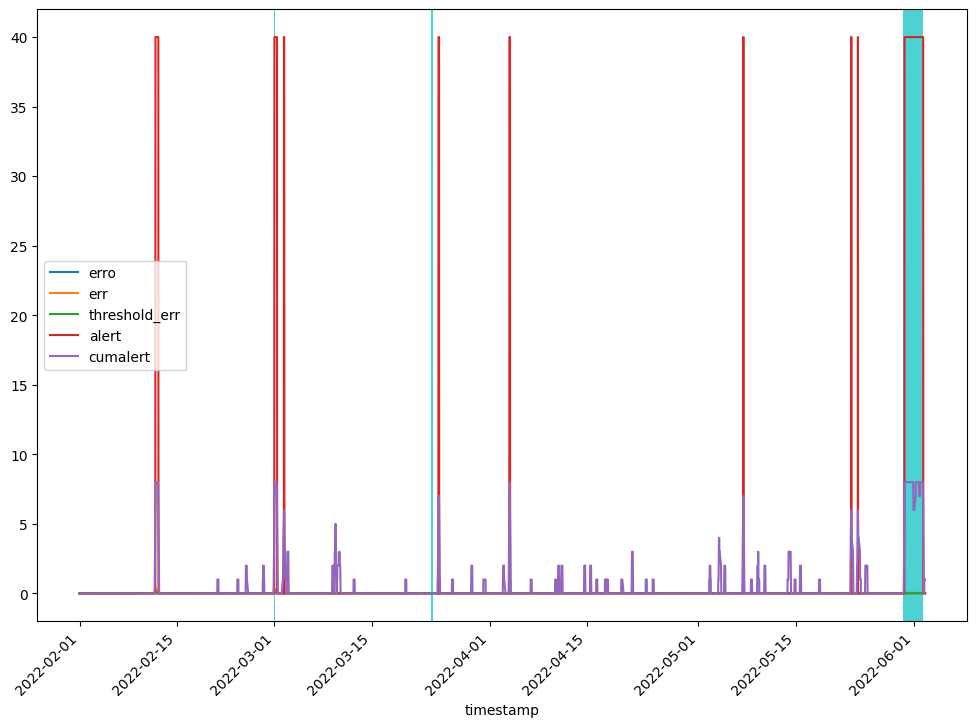

In [32]:
from collections import deque

fig, ax = plt.subplots(1,1, figsize=(12,9))

rolling_buffer = '7d'

recerr_agg_df['timestamp'] = recerr_agg_df['timestamp'].astype('datetime64[ns]')
err = recerr_agg_df.set_index('timestamp')
err.loc[:,"threshold_err"] = 0
err.loc[:,"alert"] = 0
err.loc[:,"cumalert"]=0
bufflen = int(2*24*7)#sampels_per_hour * 24 * days
buffer = deque(maxlen=bufflen)
abufflen =  int(2*4) #samples_per_hour * monitoring_hours
alertbuf = deque(maxlen=abufflen)
for i,r in err.iterrows():
    if len(buffer) < bufflen:
        buffer.append(r['err'])
        continue
    avg = np.mean(buffer)
    sigma = np.std(buffer)
    if r['err'] > avg+3*sigma:
        err.loc[i,'alert'] = 1
        alertbuf.append(1)
    else:
        alertbuf.append(0)
        buffer.append(r['err'])
    err.loc[i,'cumalert']=sum(alertbuf)

    if sum(alertbuf) >= 0.75*abufflen:
        err.loc[i,'alert'] = 40
    else:
        err.loc[i,'alert'] = 0
    err.loc[i,"threshold_err"] = avg+3*sigma
    

err.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00','2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation = 45)

([<matplotlib.axis.YTick at 0x7f6530ea8d60>,
 [Text(0, 0, 'TP2'),
  Text(0, 1, 'TP3'),
  Text(0, 2, 'H1'),
  Text(0, 3, 'DV_pressure'),
  Text(0, 4, 'Reservoirs'),
  Text(0, 5, 'Oil_temperature'),
  Text(0, 6, 'Flowmeter'),
  Text(0, 7, 'Motor_current'),
  Text(0, 8, 'COMP'),
  Text(0, 9, 'DV_eletric'),
  Text(0, 10, 'Towers'),
  Text(0, 11, 'MPG'),
  Text(0, 12, 'LPS'),
  Text(0, 13, 'Pressure_switch'),
  Text(0, 14, 'Oil_level'),
  Text(0, 15, 'Caudal_impulses')])

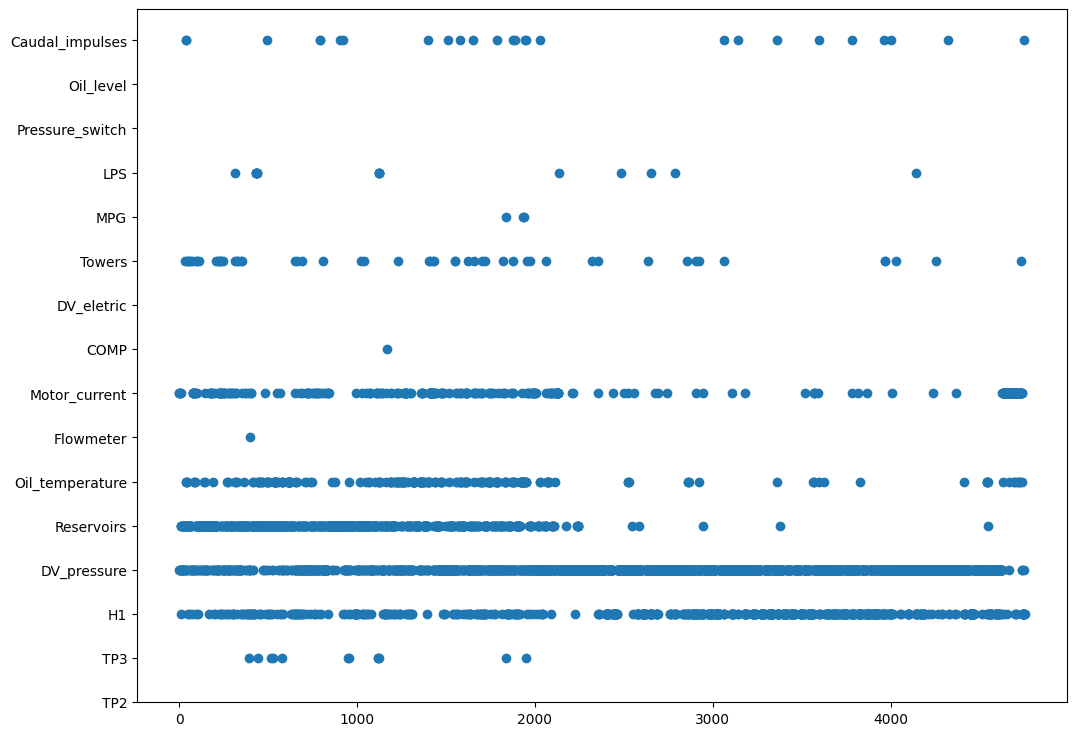

In [36]:
#last results form window of 180, 128 units, kernels 16-size (previously kernels 7)
plt.figure(figsize=(12,9))
plt.scatter(np.arange(0,len(recerr_agg_idx)),recerr_agg_idx)
ticks = realdata.columns[1:]
plt.yticks(np.arange(len(ticks)), ticks)

In [37]:
recerr_agg=np.mean(np.mean(np.abs(recerr),axis=1),axis=1)

In [38]:
sensor_err = np.mean(np.abs(recerr),axis=1)
sensorerr_agg_df=pd.DataFrame(sensor_err, columns=features)
sensorerr_agg_df['timestamp']= timestamps
sensorerr_agg_df = sensorerr_agg_df.set_index('timestamp')

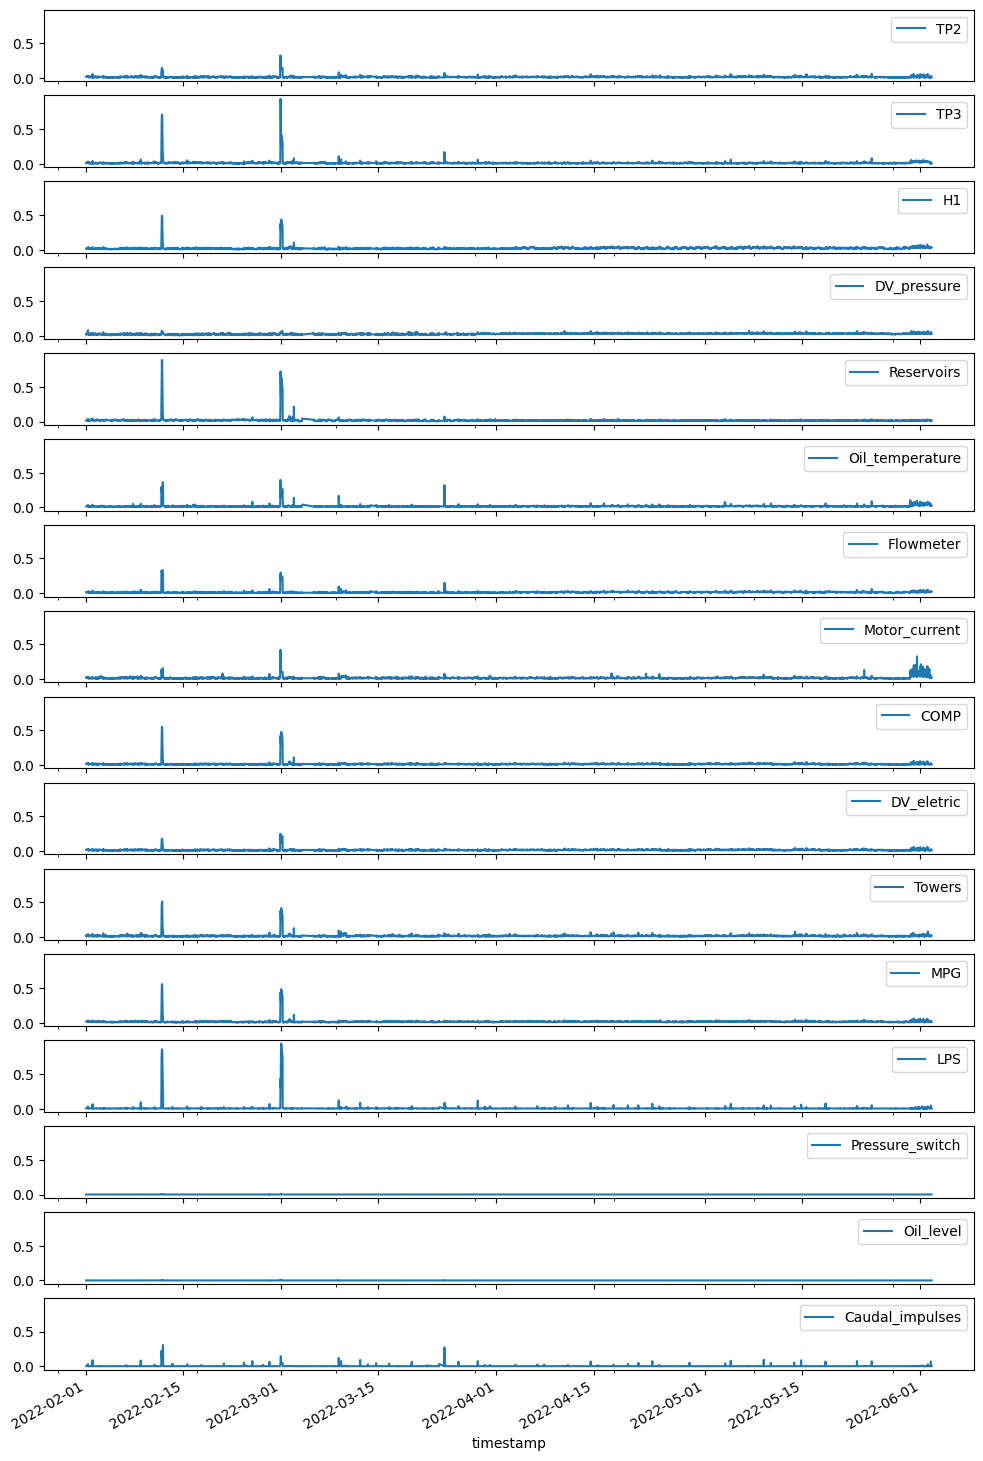

In [39]:
fig, axs = plt.subplots(len(features), figsize=(12,20),sharex=True, sharey=True)
for i,f in enumerate(features):
    sensorerr_agg_df[[f]].plot(ax=axs[i])

## Classifier

In [40]:
breaks = err['alert']-err['alert'].shift(-1)
separate_alerts = breaks[breaks<0]

In [41]:
separate_alerts

timestamp
2022-02-11 21:19:00   -40.0
2022-03-01 00:02:00   -40.0
2022-03-02 09:00:00   -40.0
2022-03-24 14:33:00   -40.0
2022-04-03 19:24:00   -40.0
2022-05-07 10:20:00   -40.0
2022-05-22 23:05:00   -40.0
2022-05-23 22:34:00   -40.0
2022-05-30 15:27:00   -40.0
Name: alert, dtype: float64

In [42]:
erri = err.reset_index()
Xerr = erri[erri['alert']>0]
Xset = erri[erri['cumalert']==0].sample(len(Xerr))

In [43]:
dsidxerr = list(Xerr.index)
dsixnormal = list(Xset.index)

In [44]:
from keras.utils import to_categorical
cl_inputX = np.concatenate((realX[dsidxerr,:,:],realX[dsixnormal,:,:]))
cl_inputy = to_categorical(np.concatenate((np.ones(len(Xerr)), np.zeros(len(Xset)))))

In [45]:
fXtrain,fXtest, ftrainy, ftesty = train_test_split(cl_inputX, cl_inputy,shuffle=False)

In [46]:
encoder.trainable = True

In [47]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 3, 10, 16)         0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 3, 10, 64)         225536    
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 3, 10, 32)         135296    
                                                                 
Total params: 360,832
Trainable params: 360,832
Non-trainable params: 0
_________________________________________________________________


In [48]:
accuracy, model = train_model(fXtrain, ftrainy, fXtrain, ftrainy, encoder) #same data, because we just want to interpret what has been learnt

2023-10-20 07:06:31.575440: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/Adam/conv_lstm1d/kernel/m/Assign' id:5508 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/conv_lstm1d/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/conv_lstm1d/kernel/m, training_2/Adam/conv_lstm1d/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-10-20 07:06:32.139549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-20 07:06:34.907460: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:3696 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manua

In [49]:
accuracy

1.0

In [50]:
predicted = model.predict(fXtrain)

2023-10-20 07:06:35.192773: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Softmax' id:3620 op device:{requested: '', assigned: ''} def:{{{node dense_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [51]:
from sklearn.metrics import f1_score
f1_score(np.argmax(ftrainy,axis=1), np.argmax(predicted,axis=1))

1.0

### Shap

In [52]:
shap_version='deep'
bg_size = 1000
absshap = True
if shap_version == 'window':
    #There is a problem with Windowed version for more than two classes
    indexes = np.arange(0, len(fXtrain))
    np.random.shuffle(indexes)
    maxid = min(bg_size, len(fXtrain))
    background_data = fXtrain[indexes[:maxid]]
    
    sv_ts = np.zeros((len(fXtrain),fXtrain.shape[1], fXtrain.shape[2]))
    sv_tr = np.zeros((len(fXtrain),fXtrain.shape[1], fXtrain.shape[2]))
    
    for i in range(len(fXtrain)):
        gtw = SlidingWindowSHAP(model, stride, window_len, background_data, fXtrain[i:i+1], model_type='lstm')
        sv_ts[i,:,:] = gtw.shap_values(num_output=ftrainy.shape[1])
    for i in range(len(fXtrain)):
        gtw = SlidingWindowSHAP(model, stride, window_len, background_data, fXtrain[i:i+1], model_type='lstm')
        sv_tr[i,:,:] = gtw.shap_values(num_output=ftrainy.shape[1])
elif shap_version == 'deep':
    indexes = np.arange(0, len(fXtrain))
    np.random.shuffle(indexes)
    maxid = min(bg_size, len(fXtrain))
    background_data = fXtrain[indexes[:maxid]]
    
    explainer = shap.DeepExplainer(model,background_data)
    shap_values_ts = explainer.shap_values(fXtrain, check_additivity=False)
    shap_values_tr = explainer.shap_values(fXtrain, check_additivity=False)
    if absshap:
        sv_ts = abs(np.array(shap_values_ts)).mean(axis=0) # This basically returns the average importance over the feature/sample
                                           # Not taking into account the sign of shap value, as it is not required
                                           # for breakpoints calculation
        sv_tr = abs(np.array(shap_values_tr)).mean(axis=0) # This basically returns the average importance over the feature/sample
                                               # Not taking into account the sign of shap value, as it is not required
                                               # for breakpoints calculation
    else:
        indexer = np.argmax(model.predict(fXtrain), axis=1)
        sv_ts=[]
        for i in range(0,len(fXtrain)):
            sv_ts.append([shap_values_ts[indexer[i]][i,:]])
        sv_ts=np.concatenate(sv_ts)
        indexer = np.argmax(model.predict(fXtrain), axis=1)
        sv_tr=[]
        for i in range(0,len(fXtrain)):
            sv_tr.append([shap_values_tr[indexer[i]][i,:]])
        sv_tr=np.concatenate(sv_tr)